In [227]:
# Clean data funtion: #
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
#string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())


def clean_text(text):
  # From the last assignment
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shadow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shadow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/shadow/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shadow/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 2: Text Classification and Neural Network
### Total Points: 100 points

In Assignment 2, you will be dealing with text classification using Multinomial Naive Bayes and Neural Networks. You will also be dealing with vector visualization. In the previous assingment you implemented Bag of Words as the feature selection method. However, in this assignment you will be using TF-IDF Vectorization instead of Bag of Words. We recommend starting with this assignment a little early as the datasets are quite large and several parts of the assignment might take long duration to execute. 

## Question 1 Text Classification

In the first question you will be dealing with 20 News Group Dataset. You are required to implement TF-IDF vectorization from scratch and perform Multinomial Naive Bayes Classification on the News Group Dataset.
You may use appropriate packages or modules for fitting the Multinomial Naive Bayes Model, however, the implementation of the TF-IDF Vectorization should be from the scratch.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Link to the original dataset: http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

You can also import the dataset from sklearn.datasets

In [228]:
#importing the libraries

import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize 
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from tqdm import tqdm


In [229]:
# Import the 20 news group dataset utilizing sklearn library
from sklearn.datasets import fetch_20newsgroups
mydata_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
mydata_test =  fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))


In [230]:
# Print the news groups(target) in the dataset
pprint(list(mydata_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [231]:
# What is the type of 'mydata_train' and 'mydata_test'
print(type(mydata_train))
print(type(mydata_test))

<class 'sklearn.utils.Bunch'>
<class 'sklearn.utils.Bunch'>


In [232]:
# Check the length of the data

print(len(mydata_train.data))
print(len(mydata_train.filenames))
print(len(mydata_test.data))
print(len(mydata_test.filenames))

11314
11314
7532
7532


### Expected Output: 
11314

11314

7532

7532

## Extracting Features from the Dataset                        (20 Points)

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

### TF-IDF Vectorization

Our model cannot simply read the text data so we convert it into numerical format. In order to convert the data into numerical format we create vectors from text.

For this particular purpose we could either employ Bag of Words or TF-IDF Vectorization

Bag of Words just creates a set of vectors containing the count of word occurrences in the document (reviews), while the TF-IDF model contains information on the more important words and the less important ones as well.

TF-IDF stands for Term Frequency-Inverse Document Frequency, which instead of giving more weight to words that occur more frequently, it gives a higher weight to words that occur less frequently.

Ref:https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,less%20important%20ones%20as%20well.

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

Term Frequency is the measure of the frequency of words in a document. It is the ratio of the number of times the word appears in a document compared to the total number of words in that document.

The words that occur rarely in the corpus have a high IDF score. It is the log of the ratio of the number of documents to the number of documents containing the word.

idf(t) = log(N/(df + 1))

In [233]:
text = mydata_train.data
test = mydata_test.data

## Preprocessing the Corpus

In [234]:
# Preprocessing the data
lines = [] 
word_list = []

for line in text:
    #tokenize the text documents and update the lists word_list and lines
    words = clean_text(line).split()
    word_list = word_list + words
    lines.append(words)

# Make sure the word_list contains unique tokens
word_list = np.unique(word_list)

# Calculate the total documents present in the corpus
total_docs = len(lines)
 
#Create a dictionary to keep track of index of each word
dict_idx = {}
counter = 0
for word in word_list:
    dict_idx[word] = counter
    counter = counter + 1

In [235]:
# Create a frequency dictionary
def frequency_dict(lines):
    '''
    lines: list containing all the tokens
    ---
    freq_word: returns a dictionary which keeps the count of the number of documents containing the given word
    '''
    freq_word = {}
    for line in lines:
        unique_words = np.unique(line)
        for word in unique_words:
            if word in freq_word:
                freq_word[word] = freq_word[word] + 1
            else:
                freq_word[word] = 1
                
    return freq_word

In [236]:
# Create a dictionary containing the frequency of words utilizing the 'frequency_dict' function

# Expect this chunk to take a comparatively longer time to execute since our dataset is large

freq_word = frequency_dict(lines)

freq_word

{'2door': 3,
 '60': 198,
 '70': 121,
 'addition': 171,
 'anyone': 1376,
 'body': 285,
 'bricklin': 2,
 'bumper': 22,
 'called': 566,
 'car': 482,
 'could': 1674,
 'day': 845,
 'door': 142,
 'early': 268,
 'email': 836,
 'engine': 164,
 'enlighten': 13,
 'front': 232,
 'funky': 5,
 'history': 298,
 'info': 343,
 'know': 2409,
 'late': 170,
 'looked': 194,
 'looking': 570,
 'made': 808,
 'model': 306,
 'name': 600,
 'please': 1160,
 'production': 71,
 'really': 1074,
 'rest': 324,
 'saw': 265,
 'separate': 133,
 'small': 432,
 'spec': 106,
 'sport': 96,
 'tellme': 1,
 'whatever': 293,
 'wondering': 181,
 'year': 1418,
 '14': 281,
 '800': 78,
 'adapter': 73,
 'add': 296,
 'answered': 69,
 'attained': 7,
 'base': 205,
 'brave': 67,
 'brief': 51,
 'card': 517,
 'clock': 97,
 'cpu': 91,
 'detailing': 11,
 'disk': 326,
 'done': 579,
 'especially': 327,
 'experience': 351,
 'fair': 117,
 'floppy': 137,
 'functionality': 36,
 'havent': 286,
 'heat': 82,
 'hour': 199,
 'knowledge': 204,
 'messag

In [237]:
# Create a function to calculate the Term Frequency

def term_frequency(document, word):
    '''
    document: list containing the entire corpus
    word: word whose term frequency is to be calculated
    ---
    tf: returns term frequency value
    '''
    counter = 0
    for word_doc in document:
        if word == word_doc:
            counter = counter + 1
    tf = counter / len(document)
    return tf

In [238]:
# Create a function to calculate the Inverse Document Frequency
 
def inverse_df(word):
    '''
    word: word whose inverse document frequency is to be calculated
    ---
    idf: return inverse document frequency value
    '''
    count = 1
    if word in freq_word and freq_word[word] > 0:
        count = freq_word[word]
    else:
        count = 1
    
    idf = np.log(total_docs/count)
    return idf

In [239]:
idf_cal = {}
for word in word_list:
    idf_cal[word] = inverse_df(word)

In [245]:
#Create a function to combine the term frequencies (TF) and inverse document (IDF) frequencies calculated above to get TF-IDF
def tfidf(sentence, dict_idx):
    '''
    sentence: list containing the entire corpus
    dict: dictionary keeping track of index of each word
    ---
    tf_idf_vec: returns computed tf-idf
    '''
    tf_idf_vec = [0] * len(dict_idx)
    for word in sentence:
        if word in dict_idx and tf_idf_vec[dict_idx[word]] == 0:
            tfidf = term_frequency(sentence, word) * idf_cal[word]
            tf_idf_vec[dict_idx[word]] = tfidf
    return tf_idf_vec

In [246]:
#Compute the vectors utilizing the 'tfidf' function created above to obtain a TF-IDF Encoded text corpus
vectors = []
for line in tqdm(lines):
    vec = tfidf(line, dict_idx)
    vectors.append(vec)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11314/11314 [00:45<00:00, 250.64it/s]


### Multinomial Naive Bayes (10 Points)

In [247]:
#Fit a Multinomial Naive Bayes Model on our dataset

model = MultinomialNB()
model = model.fit(vectors, mydata_train.target)


In [248]:
#Perform testing on the train dataset    
pred = model.predict(vectors)

In [249]:
#Calculate the F1 Score and the Accuracy

F1_score = metrics.f1_score(mydata_train.target,pred, average='weighted')
Accuracy = metrics.accuracy_score(mydata_train.target,pred)
print("F1 Score: ", F1_score)
print("Accuracy: ", Accuracy)

F1 Score:  0.8837776029534627
Accuracy:  0.8880148488598197


### Expected Output:
F1 Score: 0.9533633964397735

Accuracy: 0.9524482941488421

Your accuracy does not have to be exactly the same. This is just to give you an estimate of what could you expect your accuracy to be around.

## Question 2 Vector Visualization

In this unsupervised learning task we are going to cluster wikipedia articles into groups using T-SNE visualization after vectorization.

### Collect articles from Wikipedia (10 points)

In this section we will download articles from wikipedia and then vectorize them in the next step. You can select somewhat related topics or fetch the articles randomly. 
(Use dir() and help() functions or refer wikipedia documentation)
You may also pick any other data source of your choice instead of wikipedia.

In [3]:
#install libraries
#pip install wikipedia

In [192]:
import wikipedia
from wikipedia.exceptions import WikipediaException

'''
 Generate a list of wikipedia article to cluster 
 You can maintain a static list of titles or generate them randomly using wikipedia library
 Some topics include:
 ["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]

 You can add more topics from different categories so that we have a diverse dataset to work with. 
 Ex- About 3+ categories(groups), 3+ topics in each category, 3+ articles in each topic
'''

# selected topics
topics = ["Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]
# list of articles to be downloaded
articles = []
for topic in topics:
    sub_top = wikipedia.search(topic)
    articles = articles + sub_top[:10]

# download and store articles (summaries) in this variable
data = []
for article in articles:
    try:
        data.append(wikipedia.summary(article))
    except WikipediaException:
        print("Error in:" + article)


Error in:Machine learning


/Users/shadow/opt/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/shadow/opt/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Error in:Data
Error in:Bank of America
Error in:Bank
Error in:Visa Inc.
Error in:Mastercard
Error in:Bank
Error in:Bank of the United States
Error in:Bank of America
Error in:Swimming (sport)
Error in:Swimming pool (disambiguation)
Error in:Tennis
Error in:Rafael Nadal
Error in:2022 College Football Playoff National Championship
Error in:FIFA


In [193]:
len(data)

165

### Cleaning the Data (5 points)
In this step you will decide whether to clean the data or not. If you choose to clean, you may utilize the clean function from assignment 1.

**Question:** Why are you (not) choosing to clean the data? Think in terms of whether cleaning data will help in the clustering or not.

**Answer(1-3 sentences):** 

In [201]:
# You can use Assignment 1's clean message function
import re
import nltk
import string
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

clean_data = []
for line in data:
    clean_data.append(clean_text(line))

### Vectorize the articles (5 points)

In this step, we will vectorize the text data. You can use TfidfVectorizer() or countVectorizer() from sklearn library.

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_data)


In [203]:
print(X.shape)

(165, 4703)


### Sample Output:
(36, 1552)

### Plot Articles (10 points)
Now we will try to verify the groups of articles using T-SNE from sklearn library.

In [204]:
 from sklearn.manifold import TSNE

# call TSNE() to fit the data
X_embedded = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(X)
X_embedded.shape

(165, 2)

Plot and annotate the points with different markers for different expected groups.

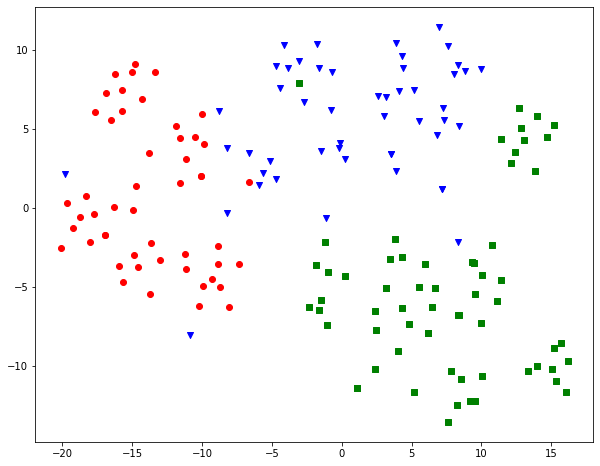

In [207]:
import matplotlib.pyplot as plt

# get a figure handle
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[0:50,0],X_embedded[0:50,1], marker = 'o', c = 'r')
ax.scatter(X_embedded[50:100,0],X_embedded[50:100,1], marker = 'v', c = 'b')
ax.scatter(X_embedded[100:165,0],X_embedded[100:165,1], marker = 's', c = 'g')

# number the points

**Question:** Comment about the categorizion done by T-SNE. Do the articles of related topics cluster together? (5 points)

**Answer(1-3 sentences):**  
  


# Question 3 Building Neural Networks

### We are gonna use Emotions Dataset for this task. We need to classify the given text into different kind of emotions like happy,sad,anger etc.., 

### We are providing train.txt and val.txt files along with this notebook. 

### Library Imports and Utility functions

### Q) Importing the datasets and do the necessary cleaning and convert the text into the vectors which are mentioned in the below code blocks. (10 points)

In [219]:

# Import the train.txt and val.txt file into pandas dataframe format 
train = pd.read_csv('Emotions-dataset/train.txt', sep=";", header=None)
test = pd.read_csv('Emotions-dataset/test.txt', sep=";", header=None)

# train 
print("=========== Train Data ===========")
print(train.head())

# validation
print("=========== Validation Data ===========")
print(test.head())
print("=========== ===========")

# and printout the train.shape and validation.shape 
print("Train Shape:", train.shape)
print("Validation Shape:", test.shape)

# expected shape of train dataset is (16000,2) and validation dataset is (2000,2)

=========== Train Data ===========
                                                   0        1
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
=========== Validation Data ===========
                                                   0        1
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
=========== ===========
Train Shape: (16000, 2)
Validation Shape: (2000, 2)


In [220]:
# clean the text in the train and validation dataframes using the clean_text function provided above
for train_loc in range(train.shape[0]):
    train.iloc[train_loc][0] = clean_text(train.iloc[train_loc][0])

In [221]:
for test_loc in range(test.shape[0]):
    test.iloc[test_loc][0] = clean_text(test.iloc[test_loc][0])

In [222]:
# initialise count vectorizer from sklearn module with default parameter
count_vec = CountVectorizer()

# fit on train dataset and transform both train and validation dataset
fit_count_train_x = count_vec.fit(list(train[0]), list(train[1]))

trans_count_train_x = fit_count_train_x.transform(list(train[0]))
trans_count_test_x = fit_count_train_x.transform(list(test[0]))


In [223]:
# initialise tfidf vectorizer from sklearn module with default parameter
tfidf_vec = TfidfVectorizer()

# fit on train dataset and transform both train and validation dataset
fit_tfidf_train_x = tfidf_vec.fit(list(train[0]), list(train[1]))

trans_count_train_x = fit_tfidf_train_x.transform(list(train[0]))
trans_count_test_x = fit_tfidf_train_x.transform(list(test[0]))



In [224]:
# initialise label encoder from sklearn module
label_vec = preprocessing.LabelEncoder()

# fit on train labels and transform both train and validation labels
fit_label_train_x = label_vec.fit(list(train[1]))

trans_label_train_x = fit_label_train_x.transform(list(train[1]))
trans_label_test_x = fit_label_train_x.transform(list(test[1]))

In [ ]:
# convert the labels into one hot encoding form


### Q) Build the neural networks using tensorflow keras by following the below instructions. Evaluate the model on different metrics and comment your observations. (15 points)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

tf.random.set_seed(42)


# complete this linear model in tensorflow
def build_model(X):

  # layer 1 : input layer
    inp = tf.keras.Input((X.shape[1],))

  # layer 2 : add the dense layer with 2048 units and relu activation
    x = layers.Dense(2048, activation='relu')(inp)
    
  # layer 3 : add the dropout layer with dropout rate of 0.5
    x = layers.Dropout(0.5)(x)
  
  # layer 4 : add the dense layer with 1024 units with tanh activation and with l2 regularization
    x = layers.Dense(1024, activation='tanh', kernel_regularizer=regularizers.L2(1e-4))(inp)

  # layer 5 : add the dropout layer with dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

  # layer 6 : add the dense layer with 512 units with tanh activation and with l2 regularization
    x = layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.L2(1e-4))(inp)

  # layer 7 : add the dropout layer with dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

  # layer 8 : add the dense layer with 256 units with tanh activation and with l2 regularization
    x = layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.L2(1e-4))(inp)

  # layer 9 : add the dropout layer with dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

  # layer 10 : add the dense layer with 128 units with tanh activation and with l2 regularization
    x = layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.L2(1e-4))(inp)

  # layer 11 : add the dropout layer with dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

  # layer 12 : output layer with units equal to number of classes and activation as softmax
    x = layers.Dense(6, activation='softmax')(x)

  # use loss as categorical crossentropy, optimizer as rmsprop and evaluate model on auc,precision,recall,accuracy 
    model = tf.keras.Model(inp, x)
    
    auc = tf.keras.metrics.AUC()
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    
    model.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics = [auc, precision, recall, 'accuracy'])
    
    return model


In [1]:
# call the build_model function and initialize the model
model = build_model(train)

NameError: name 'build_model' is not defined

In [ ]:
# train and validate the model on the count vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)

In [ ]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations

In [ ]:
# again call the build_model function and initialize the model

In [ ]:
# train and validate the model on the tfidf vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)

In [ ]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations

## Question 4 Theory Question  

What is the difference between Count Vectorizer, TFIDF, Word2Vec and Glove? (5 points)

**Answer:**

For generating word vectors, both unsupervised models - Glove and Word2vec can be used. Mechanism of generating word vectors is the main difference between them. The word vectors generated by either of these models can be used for a wide variety of tasks ranging such as finding words that are semantically similar to a word, representing a word when it is being input to a downstream model. A word embedding representation of a word captures more information about a word than just a one-hot representation of the word, since the former captures semantic similarity of that word to other words whereas the latter representation of the word is equidistant from all other words. Tf-idf is a scoring scheme for words - that is a measure of how important a word is to a document.

In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently. And to overcome this, we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

From a practical usage standpoint, while tf-idf is a simple scoring scheme and that is its key advantage, word embeddings may be a better choice for most tasks where tf-idf is used, particularly when the task can benefit from the semantic similarity captured by word embeddings.

What is the significant difference between the Niave Bayes Implementation using Bag of Words and TF-IDF? (5 points)

**Answer:**

As we know Bag of Words just creates a set of vectors containing the count of word occurrences in the document, while the TF-IDF model contains information on the more important words and the less important ones as well.

The tf-idf is an statistic that increases with the number of times a word appears in the document, penalized by the number of documents in the corpus that contain the word. Using method - sklearn.feature_extraction.text, we can achieve this.

Where as the term “bag of words” is widely used as the selected document to be processed under the context of Naive Bayes as well as while depicting the document itself as a bag. Also, each vocabulary in the texture as the items in the bag by permitting multiple occurrences.

The significant advantage of using TF-IDF is that it enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document. Then, documents with similar, relevant words will have similar vectors, which is what we are looking for in a machine learning algorithm.